In [1]:
import pandas as pd
import base
import os
import re

2024-01-05 04:49:18.192858: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 04:49:18.229983: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-05 04:49:18.230021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-05 04:49:18.230999: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-05 04:49:18.237305: I tensorflow/core/platform/cpu_feature_guar

In [2]:
SEED = 42
base.fix_seed(SEED)

desired_directory = '/home/jovyan/work/spectrum/'
os.chdir(desired_directory)

In [40]:
df_neg_ok_data2 = pd.read_csv('Data/02_basedata/neg/neg2.csv')

In [41]:
df = pd.read_csv('Data/02_basedata/df.csv')
df_neg = df[df['Adducttype'].str.contains('\]\-') | df['Adducttype'].str.contains('\]2\-')].drop('Unnamed: 0', axis=1)
df_neg_select = df_neg.merge(df_neg_ok_data2[['Metabolitename', 'dataset', 'AlignmentID']].reset_index().rename(columns={'index':'index_ID'}),
                             on=['Metabolitename', 'dataset', 'AlignmentID'])

".ms" fileの作成

In [3]:
invalid_chars = r'[\\/:*?"<>|]'

for i in range(len(df_neg_select)):
    compound = df_neg_select['Metabolitename'][i]
    formula = df_neg_select['Formula'][i]
    parentmass = df_neg_select['AverageMz'][i]
    ionization = df_neg_select['Adducttype'][i]
    
    ms2_data = df_neg_select['MSMSspectrum'][i]
    elements = ms2_data.split()  
    id = df_neg_select.index.tolist()[i]
    metabolite = re.sub(invalid_chars, '_', df_neg_select['Metabolitename'][i])
    ontology = re.sub(invalid_chars, '_', df_neg_select['Ontology'][i])
    name_ont = f"{id}_{metabolite}_{ontology}"

    ms2_split_data = []
    for element in elements:
        parts = element.split(':')
        ms2_split_data.append(f"{parts[0]} {parts[1]}")

    output_file = f"Data/04_canopus/neg/ms2_spectrum_ms_neg3/{name_ont}.ms"
    with open(output_file, 'w', newline='') as file:
        
        file.write(f">compound {metabolite}_{ontology}\n")
        file.write(f">formula {formula}\n")
        file.write(f">parentmass {parentmass}\n")
        file.write(f">ionization {ionization}\n")
        
        file.write(">ms2\n")
        file.write('\n'.join(ms2_split_data)) 

In [ ]:
import zipfile
import os
import re

folder_path = 'Data/04_canopus/neg/s2_spectrum_ms_neg3'
zip_filename = 'Data/04_canopus/neg/ms2_spectrum_ms_neg3.zip'

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for foldername, subfolders, filenames in os.walk(folder_path):
        for filename in filenames:
            if filename.endswith('.ms'):
                file_path = os.path.join(foldername, filename)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

Import::7918/8163

canopusでの予測結果の読み込み

In [43]:
df_canopus = pd.read_csv('Data/04_canopus/neg/canopus_compound_summary_neg2.tsv', sep="\t")
df_canopus['index_id'] = df_canopus['id'].apply(lambda x: x.split("_")[1])
df_canopus_ = df_canopus[['id','ClassyFire#subclass','ClassyFire#level 5','index_id']]
df_canopus_['index_id'] = df_canopus_['index_id'].astype(int)

/tmp/ipykernel_1373877/3286587303.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_canopus_['index_id'] = df_canopus_['index_id'].astype(int)


使うサブクラスの選択

In [47]:
select_ont = pd.read_csv('Data/04_canopus/neg/subclass_ont_select_neg.csv')

df_ytest = pd.read_csv('Data/04_canopus/neg/df_neg_ytest.csv').rename(columns={'Unnamed: 0':'index_ID'})
df_ytest = df_ytest[df_ytest['Ontology'].isin(select_ont.Ontology.tolist())].merge(select_ont, how='left', on='Ontology')

In [48]:
df_neg_select2 = df_neg_select.reset_index()[['index','index_ID']].rename(columns={'index':'index_id'}).astype(int)
df_model_canopus = df_neg_select2.merge(df_ytest, how='right', on='index_ID').merge(df_canopus_, how='left', on='index_id').\
drop(columns='index_id').sort_values('index_ID')

サブクラスごとの正答数を整理

In [50]:
subclasslist = ['Glycerophosphoethanolamines',
 'Glycerophosphocholines',
 'Ceramides',
 'Glycerophosphoinositols',
 'Glycerophosphoglycerols',
 'Glycerophosphoserines',
 'Phosphosphingolipids',
 'Fatty acids and conjugates']

df_neg_cano_class_pred = pd.DataFrame(columns=['Subclass','total', 'canopus_export','canopus_corpred', 'canopus_midpred'])

for i in subclasslist:
    df_model_canopus_i = df_model_canopus[df_model_canopus['subclass'] == i]
    export_number = len(df_model_canopus_i) - len(df_model_canopus_i[df_model_canopus_i['ClassyFire#subclass'].isna()])
    correct_predictions = len(df_model_canopus_i[df_model_canopus_i['ClassyFire#subclass'] == i])
    mispred_number = export_number - correct_predictions
    total_samples = len(df_model_canopus_i)

    new_row = {'Subclass': i,
               'total':total_samples,
               'canopus_export': export_number,
               'canopus_corpred': correct_predictions,
               'canopus_midpred': mispred_number}
    
    df_neg_cano_class_pred = pd.concat([df_neg_cano_class_pred, pd.DataFrame([new_row])], ignore_index=True)
    
df_neg_cano_class_pred.to_csv('Data/04_canopus/neg/df_neg_canopus_subclass_pred.csv', index=False)

モデルの予測結果と並べる

In [51]:
df_neg_model_subclass_pred = pd.read_csv('Data/04_canopus/neg/df_neg_subclass_pred.csv')

In [52]:
df_neg_model_subclass_pred2 = df_neg_model_subclass_pred.merge(df_neg_cano_class_pred, how='inner', on='Subclass').drop(columns='total')
df_neg_model_subclass_pred2.to_csv('Data/04_canopus/neg/df_neg_model_canopus_subclass_pred.csv', index=False)
df_neg_model_subclass_pred2

,Subclass,Correct_Predictions,Incorrect_Predictions,Total,canopus_export,canopus_corpred,canopus_midpred
0,Glycerophosphoethanolamines,410,1,411,289,257,32
1,Glycerophosphocholines,415,2,417,216,210,6
2,Ceramides,193,1,194,154,154,0
3,Glycerophosphoinositols,147,1,148,72,72,0
4,Glycerophosphoglycerols,74,2,76,48,48,0
5,Glycerophosphoserines,76,3,79,71,70,1
6,Phosphosphingolipids,93,0,93,41,41,0
7,Fatty acids and conjugates,9,2,11,7,1,6


level5での正答率

In [55]:
df_model_canopus_level5 = df_model_canopus[['ClassyFire#subclass','ClassyFire#level 5']].drop_duplicates().dropna().sort_values('ClassyFire#subclass')

subclasslist = pd.DataFrame(df_model_canopus_level5['ClassyFire#subclass'].value_counts()).reset_index().query('count > 1')['ClassyFire#subclass'].tolist()

リゾ体との区別ができる PC/PE/PG/PS/PI だけを選択

In [57]:
df_model_canopus_level5_s = df_model_canopus[df_model_canopus['subclass'].\
isin(['Glycerophosphoglycerols','Glycerophosphocholines','Glycerophosphoethanolamines','Glycerophosphoinositols','Glycerophosphoserines'])]
df_model_canopus_level5_s = df_model_canopus_level5_s[~df_model_canopus_level5_s['Ontology'].isin(['HBMP','LNAPE'])]

In [58]:
level5_to_class_dict = {
'1-alkyl,2-acylglycero-3-phosphocholines':'PC',
'Lysophosphatidylcholines':'LPC',
'1-(1Z-alkenyl),2-acyl-glycerophosphocholines':'PC',
'Phosphatidylcholines':'PC',
'Phosphatidylethanolamines':'PE',
'1-(1Z-alkenyl),2-acylglycerophosphoethanolamines':'PE',
'Lysophosphatidylglycerols':'LPG',
'Phosphatidylglycerols':'PG',
'Lysophosphatidylinositols':'LPI',
'Phosphatidylinositols':'PI',
'Lysophosphatidylserines':'LPS',
'Phosphatidylserines':'PS'
}

df_model_canopus_level5_s['level5_to_class'] = df_model_canopus_level5_s['ClassyFire#level 5'].map(level5_to_class_dict)
df_model_canopus_level5_s['ontology_to_class'] = df_model_canopus_level5_s['Ontology'].str.replace('Ether', '')

In [59]:
df_model_ont = pd.read_csv('Data/04_canopus/neg/df_neg_subclass_pred_ont.csv').rename(columns={'index':'index_ID'})[['index_ID','pred_ont']]

In [60]:
df_model_canopus_level5_s2 = df_model_canopus_level5_s.merge(df_model_ont, how='inner', on='index_ID')

In [61]:
df_model_canopus_level5_s2_cano = pd.DataFrame(df_model_canopus_level5_s2[['ontology_to_class','level5_to_class']].fillna('NA').value_counts()).reset_index().sort_values('ontology_to_class')
df_model_canopus_level5_s2_model = pd.DataFrame(df_model_canopus_level5_s2[['ontology_to_class','pred_ont']].fillna('NA').value_counts()).reset_index().sort_values('ontology_to_class')

In [62]:
import pandas as pd

classlist = df_model_canopus_level5_s2['ontology_to_class'].drop_duplicates().tolist()

df_model_canopus_level5_s2_cano_result = pd.DataFrame(columns=['class', 'correct_pred', 'non_pred', 'mis_pred', 'total_number'])


for i in classlist:
    df_model_canopus_level5_s2_i = df_model_canopus_level5_s2_cano[df_model_canopus_level5_s2_cano['ontology_to_class'] == i]
    
    if not df_model_canopus_level5_s2_i.empty:  # DataFrameが空でないことを確認
        correct_pred_values = df_model_canopus_level5_s2_i[df_model_canopus_level5_s2_i['level5_to_class'] == i]['count'].values
        non_pred_values = df_model_canopus_level5_s2_i[df_model_canopus_level5_s2_i['level5_to_class'] == "NA"]['count'].values
        mis_pred_values = df_model_canopus_level5_s2_i[~df_model_canopus_level5_s2_i['level5_to_class'].isin([i, "NA"])]['count'].values
      
        if len(correct_pred_values) > 0:
            correct_pred = correct_pred_values[0]
        else:
            correct_pred = 0

        if len(non_pred_values) > 0:
            non_pred = non_pred_values[0]
        else:
            non_pred = 0

        if len(mis_pred_values) > 0:
            mis_pred = mis_pred_values[0]
        else:
            mis_pred = 0

        number = correct_pred + non_pred + mis_pred

        df_model_canopus_level5_s2_cano_result = pd.concat([df_model_canopus_level5_s2_cano_result,\
                                                       pd.DataFrame({'class': [i], 'correct_pred': [correct_pred], 'non_pred': [non_pred], 'mis_pred': [mis_pred], 'total_number': [number]})])

df_model_canopus_level5_s2_cano_result = df_model_canopus_level5_s2_cano_result.reset_index(drop=True)

df_model_canopus_level5_s2_cano_resultratio = df_model_canopus_level5_s2_cano_result.copy()
df_model_canopus_level5_s2_cano_resultratio['subclass'] = ['Glycerophosphocholines','Glycerophosphoethanolamines','Glycerophosphoglycerols','Glycerophosphoinositols','Glycerophosphoserines','Glycerophosphocholines','Glycerophosphoethanolamines','Glycerophosphoglycerols','Glycerophosphoinositols','Glycerophosphoserines']
df_model_canopus_level5_s2_cano_resultratio['correct_pred'] = df_model_canopus_level5_s2_cano_resultratio['correct_pred'] / df_model_canopus_level5_s2_cano_resultratio['total_number']
df_model_canopus_level5_s2_cano_resultratio['non_pred'] = df_model_canopus_level5_s2_cano_resultratio['non_pred'] / df_model_canopus_level5_s2_cano_resultratio['total_number']
df_model_canopus_level5_s2_cano_resultratio['mis_pred'] = df_model_canopus_level5_s2_cano_resultratio['mis_pred'] / df_model_canopus_level5_s2_cano_resultratio['total_number']

In [63]:
df_model_canopus_level5_s2_model_result = pd.DataFrame(columns=['class', 'correct_pred', 'non_pred', 'mis_pred', 'total_number'])

for i in classlist:
    df_model_canopus_level5_s2_i = df_model_canopus_level5_s2_model[df_model_canopus_level5_s2_model['ontology_to_class'] == i]
    
    if not df_model_canopus_level5_s2_i.empty:  # DataFrameが空でないことを確認
        correct_pred_values = df_model_canopus_level5_s2_i[df_model_canopus_level5_s2_i['pred_ont'] == i]['count'].values
        non_pred_values = df_model_canopus_level5_s2_i[df_model_canopus_level5_s2_i['pred_ont'] == "NA"]['count'].values
        mis_pred_values = df_model_canopus_level5_s2_i[~df_model_canopus_level5_s2_i['pred_ont'].isin([i, "NA"])]['count'].values
      
        if len(correct_pred_values) > 0:
            correct_pred = correct_pred_values[0]
        else:
            correct_pred = 0

        if len(non_pred_values) > 0:
            non_pred = non_pred_values[0]
        else:
            non_pred = 0

        if len(mis_pred_values) > 0:
            mis_pred = mis_pred_values[0]
        else:
            mis_pred = 0

        number = correct_pred + non_pred + mis_pred

        df_model_canopus_level5_s2_model_result = pd.concat([df_model_canopus_level5_s2_model_result,\
                                                       pd.DataFrame({'class': [i], 'correct_pred': [correct_pred], 'non_pred': [non_pred], 'mis_pred': [mis_pred], 'total_number': [number]})])

df_model_canopus_level5_s2_model_result = df_model_canopus_level5_s2_model_result.reset_index(drop=True)

df_model_canopus_level5_s2_model_resultratio = df_model_canopus_level5_s2_model_result.copy()
df_model_canopus_level5_s2_model_resultratio['subclass'] = ['Glycerophosphocholines','Glycerophosphoethanolamines','Glycerophosphoglycerols','Glycerophosphoinositols','Glycerophosphoserines','Glycerophosphocholines','Glycerophosphoethanolamines','Glycerophosphoglycerols','Glycerophosphoinositols','Glycerophosphoserines']
df_model_canopus_level5_s2_model_resultratio['correct_pred'] = df_model_canopus_level5_s2_model_resultratio['correct_pred'] / df_model_canopus_level5_s2_model_resultratio['total_number']
df_model_canopus_level5_s2_model_resultratio['non_pred'] = df_model_canopus_level5_s2_model_resultratio['non_pred'] / df_model_canopus_level5_s2_model_resultratio['total_number']
df_model_canopus_level5_s2_model_resultratio['mis_pred'] = df_model_canopus_level5_s2_model_resultratio['mis_pred'] / df_model_canopus_level5_s2_model_resultratio['total_number']

In [64]:
df_model_canopus_level5_s2_cano_resultratio = df_model_canopus_level5_s2_cano_resultratio.sort_values('class')

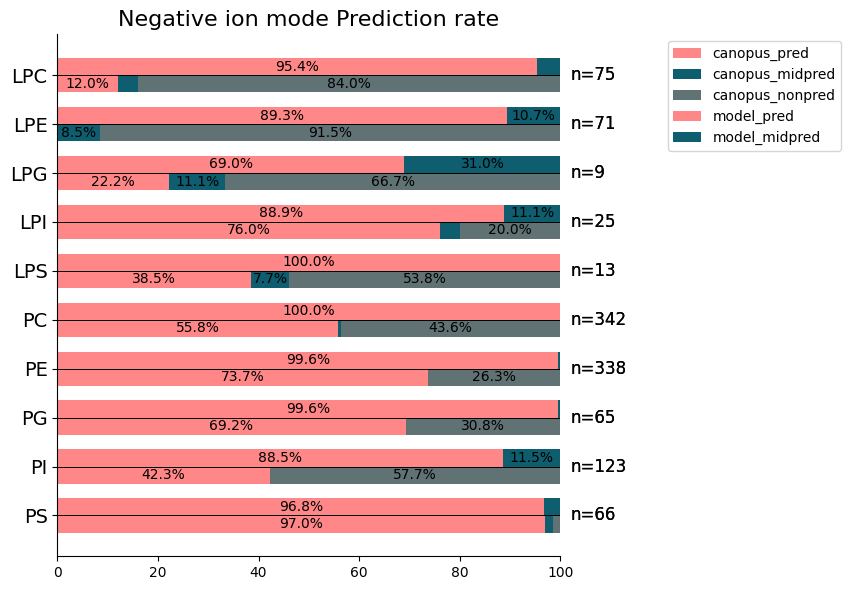

In [65]:
import matplotlib.pyplot as plt
import numpy as np

df_neg_cano = df_model_canopus_level5_s2_cano_resultratio.copy()
df_neg_cano[['correct_pred','non_pred','mis_pred']] = df_neg_cano[['correct_pred','non_pred','mis_pred']] *100

df_neg_model =  df_model_canopus_level5_s2_model_resultratio.copy()
df_neg_model[['correct_pred','mis_pred']] = df_neg_model[['correct_pred','mis_pred']] *100

# Create a bar chart for model data
fig, ax = plt.subplots(figsize=(9, 6))
width = 0.35  # Width of each bar

y = np.arange(len(df_neg_cano['class']))
custom_colors = ['#ff8787','#0e5e6f','#ff8787','#0e5e6f','#607274']  

# Plot model_1st_correct and model_mispredict bars
ax.barh(y + width/2, df_neg_cano['correct_pred'], width, label='canopus_pred', color=custom_colors[2])
ax.barh(y + width/2, df_neg_cano['mis_pred'], width, label='canopus_midpred', color=custom_colors[3], left=df_neg_cano['correct_pred'])
ax.barh(y + width/2, df_neg_cano['non_pred'], width, label='canopus_nonpred', color=custom_colors[4], left=df_neg_cano['correct_pred']+df_neg_cano['mis_pred'])
ax.barh(y - width/2, df_neg_model['correct_pred'], width, label='model_pred', color=custom_colors[0])
ax.barh(y - width/2, df_neg_model['mis_pred'], width, label='model_midpred', color=custom_colors[1], left=df_neg_model['correct_pred'])

ax.set_ylabel('Class')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Negative ion mode Prediction rate', fontsize=16)
ax.set_yticks(y)
ax.set_yticklabels(df_neg_cano['class'])
ax.legend(loc='upper left', bbox_to_anchor=(1.2, 1))

bars1= df_neg_cano[['correct_pred','mis_pred','non_pred']]
bars2= df_neg_model[['correct_pred','mis_pred','non_pred']]

  
for n in bars1:
    for i, (cs, ab, pc, sn) in enumerate(zip(bars1.iloc[:, 0:].cumsum(1)[n],
                                          bars1[n], bars1[n],df_neg_cano['total_number'])):
        if pc > 5.0:  # 0.0% のとき表示しない
            plt.text(cs - ab / 2, i + width/2, str(np.round(pc, 1)) + '%',
                     va='center', ha='center', rotation=0, fontsize=10)
        plt.text(100 + 2, i, f'n={int(sn)}', va='center', ha='left', fontsize=12, alpha=0.8)

for n in bars2:
    for i, (cs, ab, pc) in enumerate(zip(bars2.iloc[:, 0:].cumsum(1)[n],
                                          bars2[n], bars2[n])):
        if pc > 5.0:  # 0.0% のとき表示しない
            plt.text(cs - ab / 2, i - width/2, str(np.round(pc, 1)) + '%',
                     va='center', ha='center', rotation=0, fontsize=10)
            

for i in range(len(df_neg_cano)):
    plt.axhline(i, color='black', linewidth=0.7)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.gca().invert_yaxis()
plt.yticks(size = 14)
plt.tight_layout()
plt.savefig('Data/svg/test/canopus/neg_canopus-vs-model_selectclass.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()